[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange.svg)](https://nbviewer.org/github/maciejskorski/enhanced-pll-trng/blob/main/src/TemperatureAttack.ipynb)

# Summary

In [1]:
# -*- coding: utf-8 -*-

# Universite Jean Monnet
# Laboratoire Hubert Curien
# Saint-Etienne

# Nathalie Bochard

# PLL-based TRNG - animated plot
# successive reordered Tq periods
#

import numpy as np
from matplotlib import pyplot as plt

## #########################################
## variables set
## #########################################

filename = "../data/TemperatureAttack/S6_C_freezing attack_km476_kd495_dff.bin"

KM = 476
KD = 495

# nb of periods used to compute variance chunk
N_BATCH = 4096

## #########################################
## functions definition
## #########################################


def read_dff(filename, KM, KD):
    ###############################
    """Read dff bits from the raw file. Return a matrix of shape (n_cycles, KD)"""
    bytes_data = np.fromfile(filename, dtype="uint8")  # read bytes
    bits_data = np.unpackbits(bytes_data, axis=None, count=None, bitorder="little")  # unpack to bits
    bits_data = bits_data.reshape((-1, 32))[:, ::-1].ravel()  # reverse bits order in blocks of 32
    bits_data = np.resize(bits_data, (len(bits_data) // KD, KD))  # reshape to cycles
    return bits_data


## #########################################
## main program
## #########################################

# VarMeanVect = []
VarVect = []

dff_data = read_dff(filename, KM, KD)
counter_data = dff_data.sum(-1)
counter_data.shape

(517171,)

In [2]:
import pandas as pd

var_data = pd.DataFrame(data=counter_data).reset_index()
var_data.columns = ["timestep", "counter"]
var_data["batch"] = var_data["timestep"] // 4096
var_data["index"] = var_data["timestep"] % 4096
var_data = var_data.groupby("batch").agg({"counter": "var"})
var_data = var_data.reset_index()
var_data["attack"] = var_data["batch"] > 80
var_data.head()

,batch,counter,attack
0,0,0.971560,False
1,1,0.936629,False
2,2,0.980572,False
3,3,0.939381,False
4,4,0.900778,False


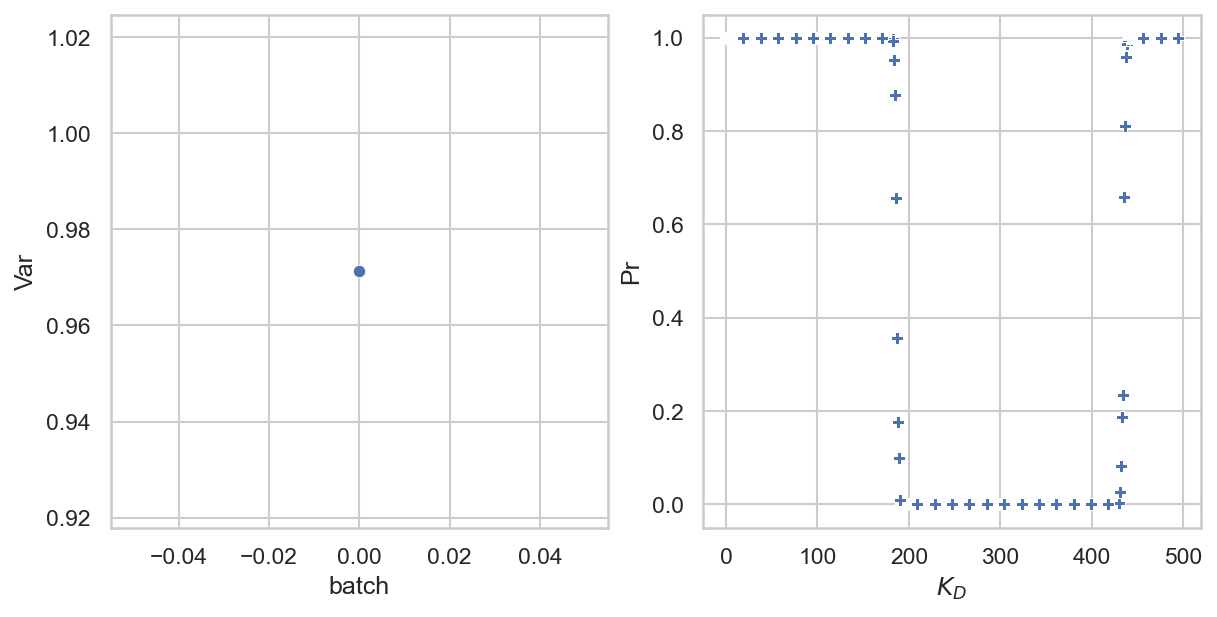

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

sns.set_theme(style="whitegrid")

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.dpi"] = 150
plt.ioff()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

variances = []


def init():
    pass


def animate(t):
    # plot reordered samples for batch t
    global variances
    ax = axs[1]
    ax.cla()
    img = dff_data[t * N_BATCH : (t + 1) * N_BATCH]
    idx = np.arange(KD) * KM % KD
    ps = img.mean(0)
    df = pd.DataFrame(data=np.vstack([idx, ps]).T, columns=["$K_D$", "Pr"])
    sns.scatterplot(data=df, x="$K_D$", y="Pr", marker="P", ax=ax)
    # plot variance until batch t
    ax = axs[0]
    ax.cla()
    cnt_var = img.sum(1).var()
    if t == 0:
        variances = [cnt_var]
    else:
        variances.append(cnt_var)
    df = pd.DataFrame(data=np.vstack([list(range(t + 1)), variances]).T, columns=["batch", "Var"])
    df["attack"] = df["batch"] >= 80
    sns.scatterplot(data=df, x="batch", y="Var", markers="P", ax=ax)


plt.close()
# anim = animation.FuncAnimation(fig, animate, frames=len(dff_data) // N_BATCH)
anim = animation.FuncAnimation(fig, animate, frames=10)
anim.save("pll_trng_temperature_attack.gif")
anim

In [4]:
anim